In [156]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import dask
import dask.dataframe as dd
from asyncio import CancelledError
from dask.delayed import delayed
from dask.distributed import Client
from cycler import cycler
import geopandas as gpd
from keplergl import KeplerGl
from IPython.display import clear_output, HTML, display, Audio, IFrame

In [35]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(4*np.pi*300*t) + np.sin(4*np.pi*240*t)

In [3]:
default_colors = ['#00c6ff', '#0078ff', '#dd2a7b']
mpl.rcParams['axes.prop_cycle'] = cycler('color', default_colors)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 18

# pd.set_option('display.max_colwidth', None)

# Methodology

In exploring dataset for this report, the group analyzed a high population density dataset amounting to a total of over 8.12Gb. In order to handle this amount of memory, the group used distributed dask clustering to handle a big amount of data surpassing the capability of the local machine/client's memory. The general workflow for the formation of this report is shown in the figure below.

1. Data Extraction
2. Data Processing
3. Exploratory Data Analysis


<center><img src="methodology.JPG" alt="Methodology"/></center>

<center><strong>Fig.1 Methodology </strong></center>

# Data Description

<center><img src="data_desc.JPG" alt="Methodology" width='750px'/></center>


<center><strong>Fig.2 Data Description </strong></center>

| Country | Alpha-3 code   |
|---------|----------------|
| GBR     | United Kingdom |
| FRA     | France         |
| ITA     | Italy          |
| ESP     | Spain          |
| PRT     | Portugal       |
| CHE     | Switzerland    |
| GRC     | Greece         |
| DEU     | Germany        |
| NLD     | Netherlands    |
| POL     | Poland         |
| BEL     | Belgium        |
| AUT     | Austria        |
| ISL     | Iceland        |
| HRV     | Croatia        |
| CZE     | Czechia        |
| ROU     | Romania        |
| UKR     | Ukraine        |
| HUN     | Hungary        |
| ALB     | Albania        |
| SVK     | Slovakia       |
| MNE     | Montenegro     |
| MDA     | Moldova        |
| SRB     | Serbia         |
| BLR     | Belarus        |


<center><strong>Fig.3 Country Code </strong></center>

# Data Extraction

The collected used in this report were collected from the High Resolution Population Density Maps + Demographic Estimates by CIESIN and Facebook in the AWS open data registry.

In [16]:
# Uncomment to unzip shp files
# !unzip shp.zip

Archive:  shp.zip
  inflating: de_1km.shp              
  inflating: de_1km.shx              
  inflating: gb_1km.shp              
  inflating: gb_1km.shx              


## Dask Distributed Cluster

In [4]:
client = Client('172.31.47.101:8786')
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| python  | 3.8.2.final.0 | 3.8.2.final.0 | 3.8.5.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

Client Scheduler: tcp://172.31.47.101:8786 Dashboard: http://172.31.47.101:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.04 GB


In [9]:
def get_path(country):
    """Return country CSV S3 path"""
    return dict(total_pop=('s3://dataforgood-fb-data/csv/month=2019-06'
                           f'/country={country}/type=total_population'
                           f'/{country}_total_population.csv.gz'),
                child=('s3://dataforgood-fb-data/csv/month=2019-06'
                             f'/country={country}/type=children_under_five'
                             f'/{country}_children_under_five.csv.gz'),
                elder=('s3://dataforgood-fb-data/csv/month=2019-06'
                               f'/country={country}/type=elderly_60_plus'
                               f'/{country}_elderly_60_plus.csv.gz'),
                men=('s3://dataforgood-fb-data/csv/month=2019-06'
                     f'/country={country}/type=men'
                     f'/{country}_men.csv.gz'),
                women=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=women'
                       f'/{country}_women.csv.gz'),
                reprod=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}'
                        '/type=women_of_reproductive_age_15_49'
                        f'/{country}_women_of_'
                        'reproductive_age_15_49.csv.gz'),
                youth=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}/type=youth_15_24'
                        f'/{country}_youth_15_24.csv.gz')
            )

In [6]:
# List of countries to analyze
countries = ['DEU',
             'GBR',
             'FRA',
             'ITA',
             'ESP',
             'PRT',
             'CHE',
             'GRC',
             'NLD',
             'POL',
             'BEL',
             'AUT',
             'ISL',
             'HRV',
             'CZE',
             'ROU',
             'UKR',
             'HUN',
             'ALB',
             'SVK',
             'MNE',
             'MDA',
             'SRB',
             'BLR']

In [7]:
df_countries_child = dict()
df_countries_youth = dict()
df_countries_elder = dict()

### Child

In [11]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_child = [delayed(pd.read_csv)(get_path(country)['child'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_child = dd.from_delayed(dfs_child)
    except CancelledError:
        df_child = dd.from_delayed(dfs_child)
        
    print('Repartition {}'.format(country))
    df_child = df_child.repartition(npartitions=100)
    df_countries_child[country] = df_child
    del dfs_child
    del df_child
clear_output()
print('Done')

Done


### Youth

In [10]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_youth = [delayed(pd.read_csv)(get_path(country)['youth'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_youth = dd.from_delayed(dfs_youth)
    except CancelledError:
        df_youth = dd.from_delayed(dfs_youth)
        
    print('Repartition {}'.format(country))
    df_youth = df_youth.repartition(npartitions=100)
    df_countries_youth[country] = df_youth
    del dfs_youth
    del df_youth
clear_output()
print('Done')

Done


### Elder

In [12]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_elder = [delayed(pd.read_csv)(get_path(country)['elder'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_elder = dd.from_delayed(dfs_elder)
    except CancelledError:
        df_elder = dd.from_delayed(dfs_elder)
        
    print('Repartition {}'.format(country))
    df_elder = df_elder.repartition(npartitions=100)
    df_countries_elder[country] = df_elder
    del dfs_elder
    del df_elder
clear_output()
print('Done')

Done


# Data Preprocessing

To compare the population of each country, the group merged all the datasets per category to compare different countries. We added a new column country and determine the total number of people per 30 sqm of each country. We also group the data per by 2 degrees latitude and longitude for compuational efficieny.

In [100]:
def add_features(df, country):
    """Return dataframe with required column columns"""
    df = df.copy()
    # Group data by 2 degrees
    step = 0.2
    to_bin = lambda x: np.floor(x / step) * step
    df["latbin"] = df.latitude.map(to_bin)
    df["lonbin"] = df.longitude.map(to_bin)
    df = df.groupby(['latbin', 'lonbin'])['population'].sum().to_frame()
    df['country'] = country
    return df

In [37]:
Audio(audio_data, rate=framerate, autoplay=True)

### Child

In [102]:
df_child = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_child.items()],
                     axis=0)

df_child.count().compute()

### Youth

In [104]:
df_youth = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_youth.items()],
                     axis=0)

df_youth.count().compute()

### Elder

In [105]:
df_elder = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_elder.items()],
                     axis=0)

In [ ]:
df_elder.count().compute()

# Exploratory Data Analysis

## Population density based on Age

In [107]:
total_pop_child = df_child.groupby(['country']).population.sum().compute()
total_pop_child.sort_values(inplace=True)
total_pop_youth = df_youth.groupby(['country']).population.sum().compute()
total_pop_youth.sort_values(inplace=True)
total_pop_elder = df_elder.groupby(['country']).population.sum().compute()
total_pop_elder.sort_values(inplace=True)

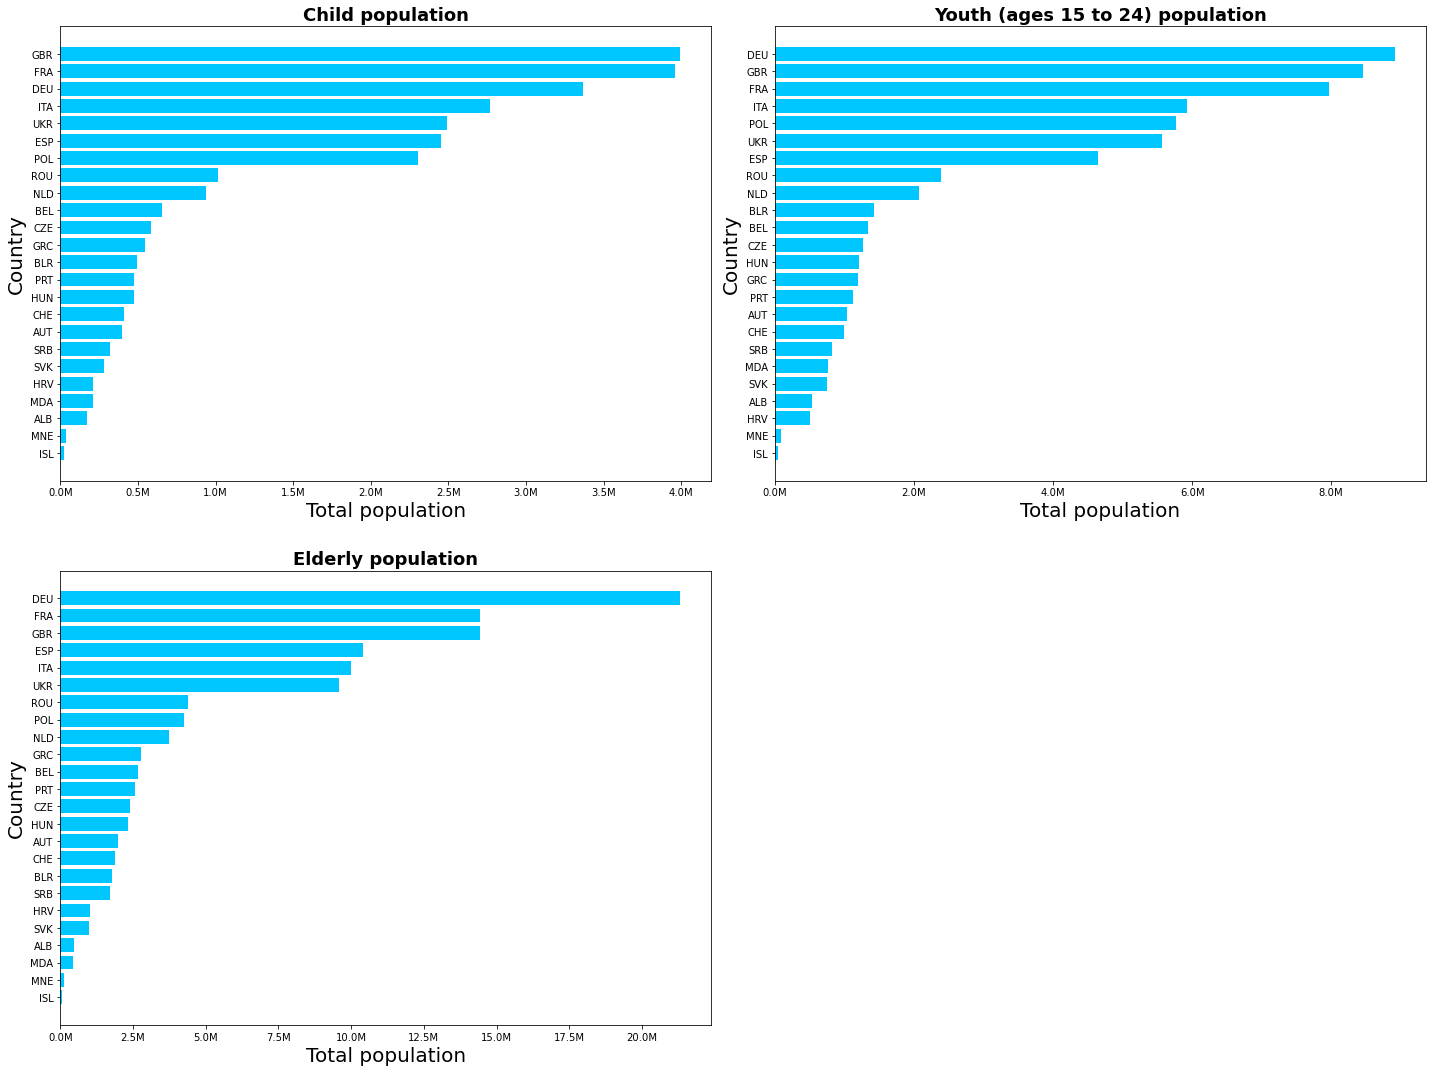

In [109]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(20, 15))

ax0 = plt.subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)

y_child = total_pop_child.index
x_child = total_pop_child.values

y_youth = total_pop_youth.index
x_youth = total_pop_youth.values

y_elder = total_pop_elder.index
x_elder = total_pop_elder.values

# Plot data
ax0.barh(y_child, x_child)
ax0.set_title('Child population')
ax0.set_ylabel('Country')
ax0.set_xlabel('Total population')

ax1.barh(y_youth, x_youth)
ax1.set_title('Youth (ages 15 to 24) population')
ax1.set_ylabel('Country')
ax1.set_xlabel('Total population')

ax2.barh(y_elder, x_elder)
ax2.set_title('Elderly population')
ax2.set_ylabel('Country')
ax2.set_xlabel('Total population')

# Change ticks
xlabels = [f'{x:.1f}M' for x in ax0.get_xticks()/1e6]
ax0.set_xticklabels(xlabels)

xlabels = [f'{x:.1f}M' for x in ax1.get_xticks()/1e6]
ax1.set_xticklabels(xlabels)

xlabels = [f'{x:.1f}M' for x in ax2.get_xticks()/1e6]
ax2.set_xticklabels(xlabels)

plt.tight_layout(h_pad=3)
plt.show()

## Geospatial analysis

In [202]:
# Configuration of DEU maps
config_deu = {'version': 'v1',
              'config': {'visState':
                         {'filters': [],
                          'layers': [
                          {'id': 'jlfb1euw',
                           'type': 'heatmap',
                           'config': {
                               'dataId': 'population',
                               'label': 'population',
                               'color': [255, 153, 31],
                               'columns': {'lat': 'latbin', 'lng': 'lonbin'},
                               'isVisible': True,
                               'visConfig': {
                                   'opacity': 0.8,
                                   'colorRange': {
                                       'name': 'Uber Viz Diverging 1.5',
                                       'type': 'diverging',
                                       'category': 'Uber',
                                       'colors': ['#00939C',
                                                  '#5DBABF',
                                                  '#BAE1E2',
                                                  '#F8C0AA',
                                                  '#DD7755',
                                                  '#C22E00']},
                                   'radius': 84},
                               'hidden': False,
                               'textLabel': [{'field': None,
                                              'color': [255, 255, 255],
                                              'size': 18,
                                              'offset': [0, 0],
                                              'anchor': 'start',
                                              'alignment': 'center'}]},
                           'visualChannels': {
                               'weightField': {
                                   'name': 'population', 'type': 'real'},
                               'weightScale': 'linear'}}],
                          'interactionConfig': {
                          'tooltip': {
                              'fieldsToShow': {
                                  'population': [{'name': 'latbin',
                                                  'format': None},
                                                 {'name': 'lonbin',
                                                  'format': None},
                                                 {'name': 'population',
                                                  'format': None}]},
                              'compareMode': False,
                              'compareType': 'absolute',
                              'enabled': True},
                             'brush': {'size': 0.5, 'enabled': False},
                             'geocoder': {'enabled': False},
                             'coordinate': {'enabled': False}},
                             'layerBlending': 'normal',
                             'splitMaps': [],
                             'animationConfig': {
                                 'currentTime': None, 'speed': 1}},
                         'mapState': {'bearing': 0,
                                      'dragRotate': False,
                                      'latitude': 51.1,
                                      'longitude': 10.4,
                                      'pitch': 0,
                                      'zoom': 5,
                                      'isSplit': False},
                         'mapStyle': {
                             'styleType': 'light',
                             'topLayerGroups': {},
                             'visibleLayerGroups': {
                                          'label': True,
                                          'road': True,
                                          'border': False,
                                          'building': True,
                                          'water': True,
                                          'land': True,
                                          '3d building': False},
                             'threeDBuildingColor': [218.82023004728686,
                                                     223.47597962276103,
                                                     223.47597962276103],
                             'mapStyles': {}}}}

# Configuration of maps
config_gbr = {'version': 'v1',
              'config': {'visState':
                         {'filters': [],
                          'layers': [
                          {'id': 'jlfb1euw',
                           'type': 'heatmap',
                           'config': {
                               'dataId': 'population',
                               'label': 'population',
                               'color': [255, 153, 31],
                               'columns': {'lat': 'latbin', 'lng': 'lonbin'},
                               'isVisible': True,
                               'visConfig': {
                                   'opacity': 0.8,
                                   'colorRange': {
                                       'name': 'Uber Viz Diverging 1.5',
                                       'type': 'diverging',
                                       'category': 'Uber',
                                       'colors': ['#00939C',
                                                  '#5DBABF',
                                                  '#BAE1E2',
                                                  '#F8C0AA',
                                                  '#DD7755',
                                                  '#C22E00']},
                                   'radius': 84},
                               'hidden': False,
                               'textLabel': [{'field': None,
                                              'color': [255, 255, 255],
                                              'size': 18,
                                              'offset': [0, 0],
                                              'anchor': 'start',
                                              'alignment': 'center'}]},
                           'visualChannels': {
                               'weightField': {
                                   'name': 'population', 'type': 'real'},
                               'weightScale': 'linear'}}],
                          'interactionConfig': {
                          'tooltip': {
                              'fieldsToShow': {
                                  'population': [{'name': 'latbin',
                                                  'format': None},
                                                 {'name': 'lonbin',
                                                  'format': None},
                                                 {'name': 'population',
                                                  'format': None}]},
                              'compareMode': False,
                              'compareType': 'absolute',
                              'enabled': True},
                             'brush': {'size': 0.5, 'enabled': False},
                             'geocoder': {'enabled': False},
                             'coordinate': {'enabled': False}},
                             'layerBlending': 'normal',
                             'splitMaps': [],
                             'animationConfig': {
                                 'currentTime': None, 'speed': 1}},
                         'mapState': {'bearing': 0,
                                      'dragRotate': False,
                                      'latitude': 54.60604517170306,
                                      'longitude': -3.819726562499494,
                                      'pitch': 0,
                                      'zoom': 5,
                                      'isSplit': False},
                         'mapStyle': {
                             'styleType': 'light',
                             'topLayerGroups': {},
                             'visibleLayerGroups': {
                                          'label': True,
                                          'road': True,
                                          'border': False,
                                          'building': True,
                                          'water': True,
                                          'land': True,
                                          '3d building': False},
                             'threeDBuildingColor': [218.82023004728686,
                                                     223.47597962276103,
                                                     223.47597962276103],
                             'mapStyles': {}}}}

In [204]:
map_gbr = KeplerGl(height=600, width=800, config=config_gbr)
# ddf_gbr = add_features(df_countries_child['GBR'],
#                        'gbr').population.reset_index().persist()
gdf_gbr = gpd.GeoDataFrame(ddf_gbr.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_gbr.lonbin.compute(),
                               ddf_gbr.latbin.compute()))
map_gbr.add_data(data=gdf_gbr, name="population")
map_gbr.save_to_html(file_name='gbr_child.html')
map_gbr.close()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to gbr_child.html!


In [191]:
map_deu = KeplerGl(height=600, width=800, config=config_deu)
ddf_deu = add_features(df_countries_youth['DEU'],
                       'DEU').population.reset_index().persist()
gdf_deu = gpd.GeoDataFrame(ddf_deu.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_deu.lonbin.compute(),
                               ddf_deu.latbin.compute()))
map_deu.add_data(data=gdf_deu, name="population")
map_deu.save_to_html(file_name='deu_youth.html')
map_deu.close()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to deu_youth.html!


In [193]:
map_deu = KeplerGl(height=600, width=800, config=config_deu)
ddf_deu = add_features(df_countries_elder['DEU'],
                       'DEU').population.reset_index().persist()
gdf_deu = gpd.GeoDataFrame(ddf_deu.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_deu.lonbin.compute(),
                               ddf_deu.latbin.compute()))
map_deu.add_data(data=gdf_deu, name="population")
map_deu.save_to_html(file_name='deu_elder.html')
map_deu.close()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to deu_elder.html!


### Child Population in United Kingdom (GBR)

In [209]:
IFrame(src='gbr_child.html', width=950, height=600)

### Youth (Ages 15 to 24) Population in Germay (DEU)

In [208]:
IFrame(src='deu_youth.html', width=950, height=600)

### Elderly Population in Germay (DEU)

In [207]:
IFrame(src='deu_elder.html', width=950, height=600)